In [1]:
# Import modules
import os
import json
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm

In [2]:
def find_highest_metric(folder_path, metric):
    max_metric_value = 0.0
    best_file = None

    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)
                metric_values = data[metric]
                max_metric_value_file = max(metric_values)
                if max_metric_value_file > max_metric_value:
                    max_metric_value = max_metric_value_file
                    best_file = file_path

    return best_file, max_metric_value

metrics_to_check = ["accuracy", "loss", "val_accuracy", "val_loss"]

# Replace 'models/training/history' with the actual path to your folder containing JSON files
folder_path = '../models/training/history'

for metric in metrics_to_check:
    best_file, max_metric_value = find_highest_metric(folder_path, metric)
    if best_file is not None:
        print(f"The file with the highest {metric} is: {best_file}")
        print(f"The highest {metric} is: {max_metric_value}")
    else:
        print(f"No JSON files found in the specified folder for {metric}.")

The file with the highest accuracy is: ../models/training/history/model_3_best_nodropout_adam_rgb_512_augment_history.json
The highest accuracy is: 0.9606190919876099
The file with the highest loss is: ../models/training/history/model_2_best_rmsprop_rgb_512_augment_history.json
The highest loss is: 1.7501258850097656
The file with the highest val_accuracy is: ../models/training/history/model_2_best_sgd_rgb_128_augment_history.json
The highest val_accuracy is: 0.5928241014480591
The file with the highest val_loss is: ../models/training/history/model_3_best_nodropout_sgd_rgb_32_augment_history.json
The highest val_loss is: 2497.628173828125


In [3]:
# Best peforming model based on validation accuracy is model_2_best_sgd_rgb_128_augment
best_model = '../models/training/history/model_2_best_sgd_rgb_128_augment_history.json'

In [4]:
# Specify how many best peforming models to show based on val_accuracy
n_best = 10
n_worst = 5

def rank_val_accuracy(folder_path):
    val_accuracy_ranking = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)
                val_accuracy = max(data["val_accuracy"])
                val_accuracy_ranking.append((file_path, val_accuracy))

    # Sort the ranking in descending order based on val_accuracy
    val_accuracy_ranking.sort(key=lambda x: x[1], reverse=True)

    return val_accuracy_ranking

val_accuracy_ranking = rank_val_accuracy(folder_path)

if val_accuracy_ranking:
    print(f"Ranking of files based on val_accuracy (showing n_best {n_best} out of {len(val_accuracy_ranking)}):")
    for rank, (file_path, val_accuracy) in enumerate(val_accuracy_ranking[:n_best], 1):
        print(f"{rank}. File: {file_path}, val_accuracy: {val_accuracy}")
    print("")
    print(f"Ranking of files based on val_accuracy (showing n_worst {n_worst} out of {len(val_accuracy_ranking)}):")
    for rank, (file_path, val_accuracy) in enumerate(val_accuracy_ranking[-n_worst:], 1):
        print(f"{rank}. File: {file_path}, val_accuracy: {val_accuracy}")
else:
    print("No JSON files found in the specified folder.")

Ranking of files based on val_accuracy (showing n_best 10 out of 96):
1. File: ../models/training/history/model_2_best_sgd_rgb_128_augment_history.json, val_accuracy: 0.5928241014480591
2. File: ../models/training/history/model_2_best_rmsprop_rgb_256_augment_history.json, val_accuracy: 0.59275883436203
3. File: ../models/training/history/model_2_best_rmsprop_rgb_128_augment_history.json, val_accuracy: 0.5925925970077515
4. File: ../models/training/history/model_2_best_adam_rgb_128_augment_history.json, val_accuracy: 0.5919560194015503
5. File: ../models/training/history/model_2_best_rmsprop_rgb_512_augment_history.json, val_accuracy: 0.5916785001754761
6. File: ../models/training/history/model_2_best_sgd_rgb_64_augment_history.json, val_accuracy: 0.5905212163925171
7. File: ../models/training/history/model_2_best_adam_rgb_256_augment_history.json, val_accuracy: 0.5899020433425903
8. File: ../models/training/history/model_2_best_sgd_rgb_256_augment_history.json, val_accuracy: 0.58926075

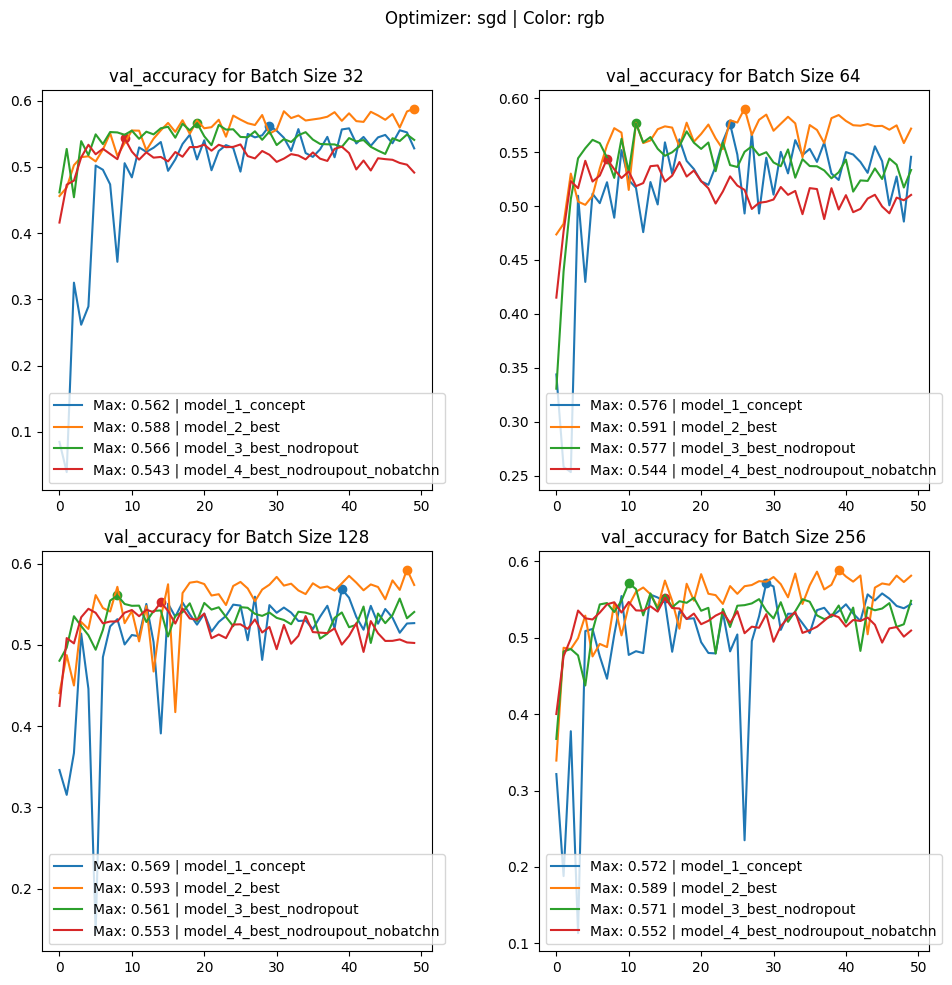

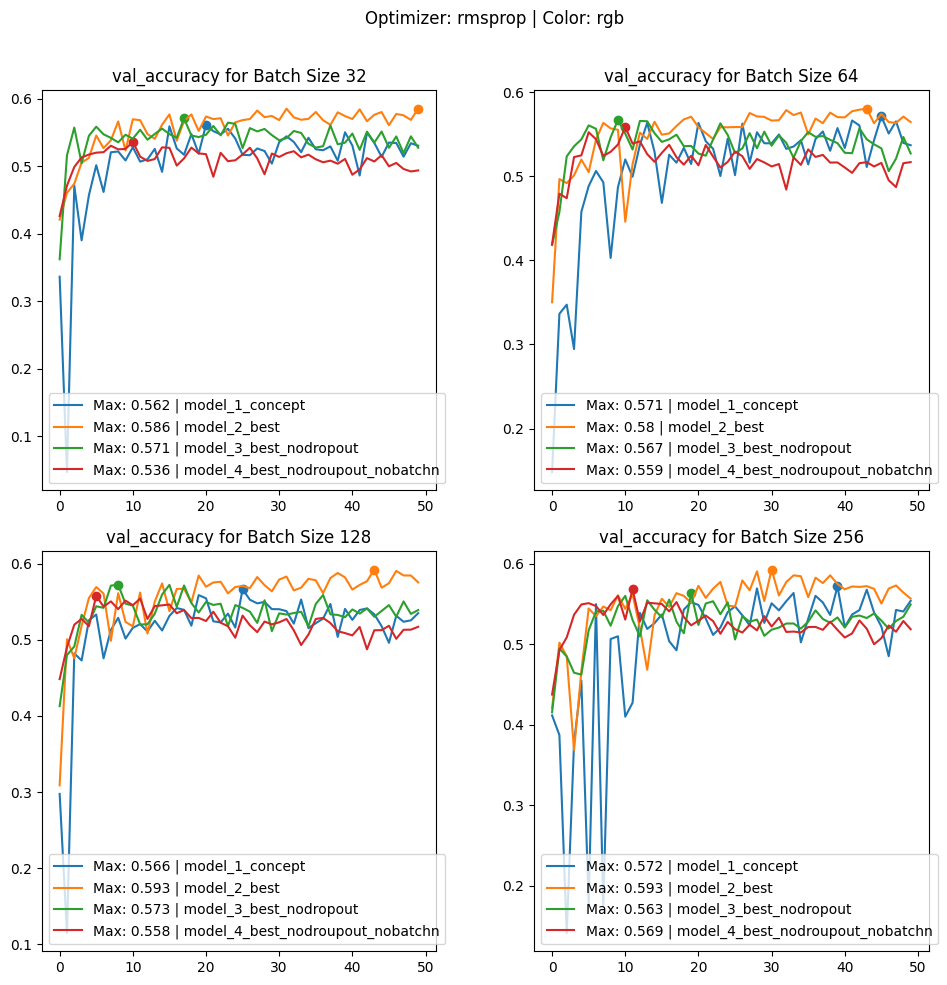

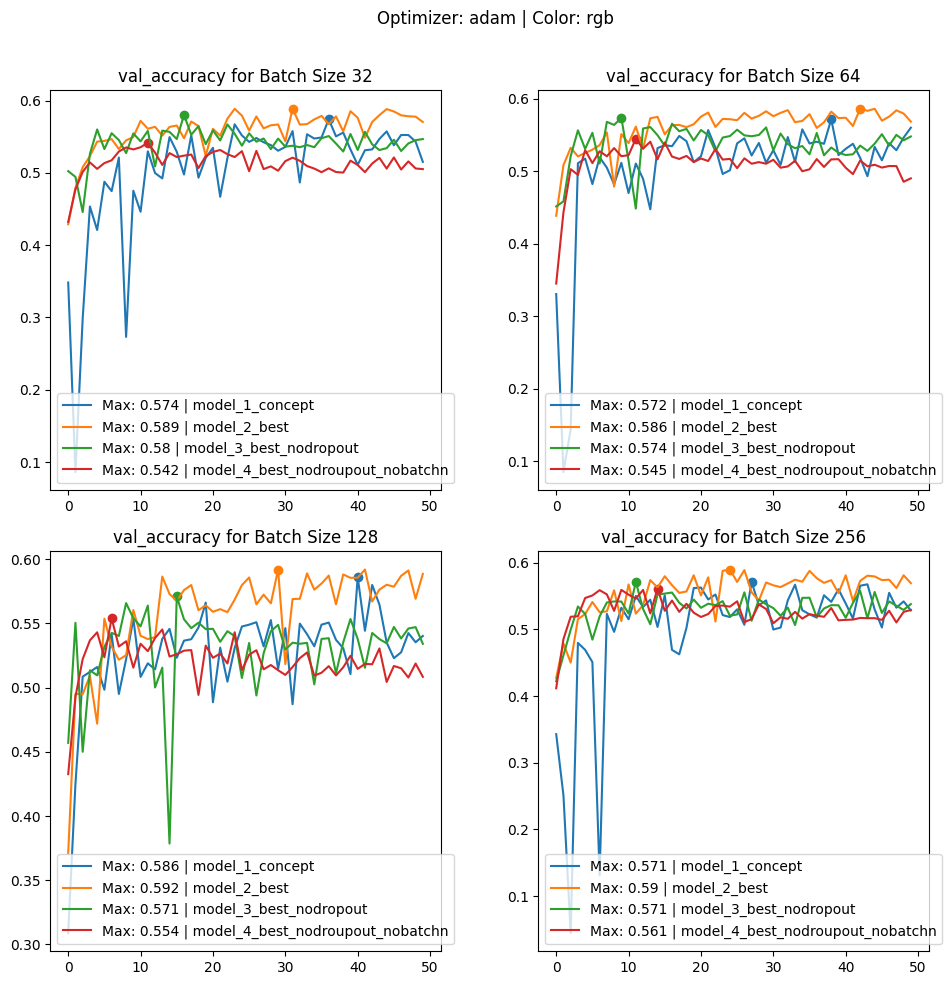

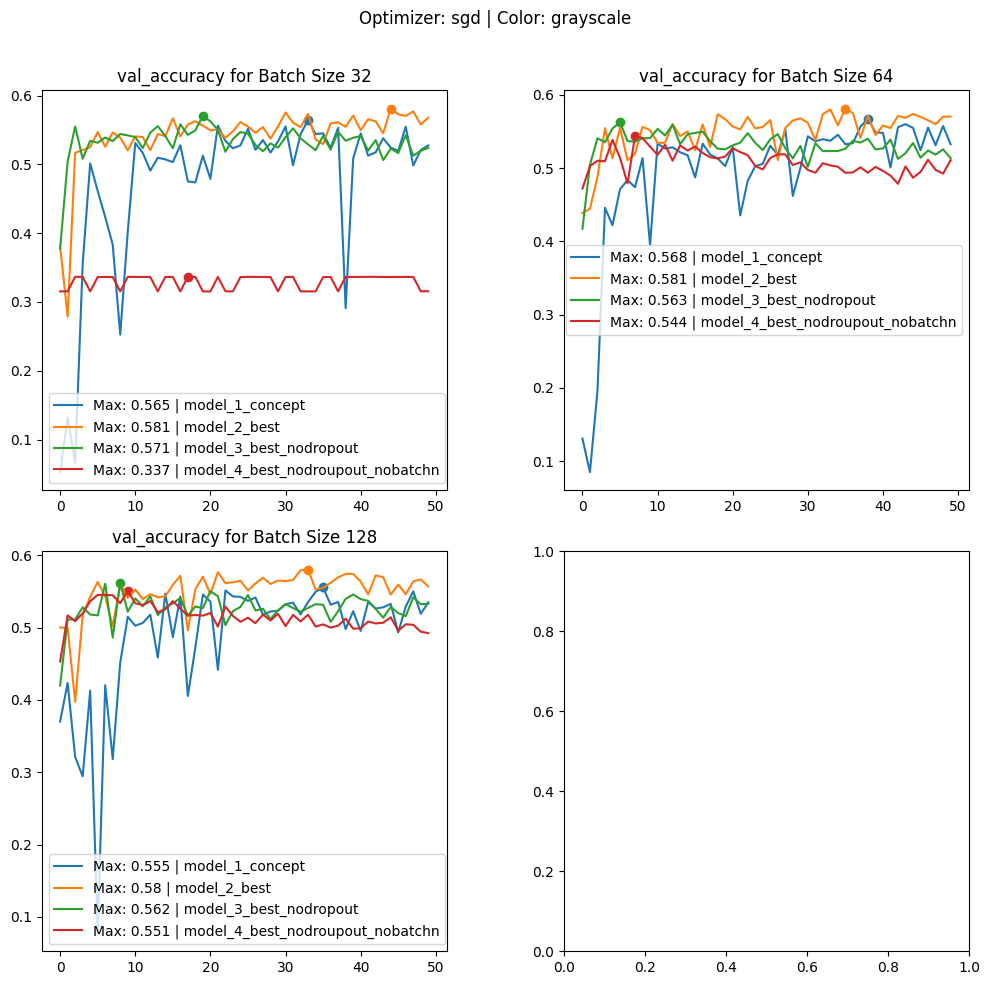

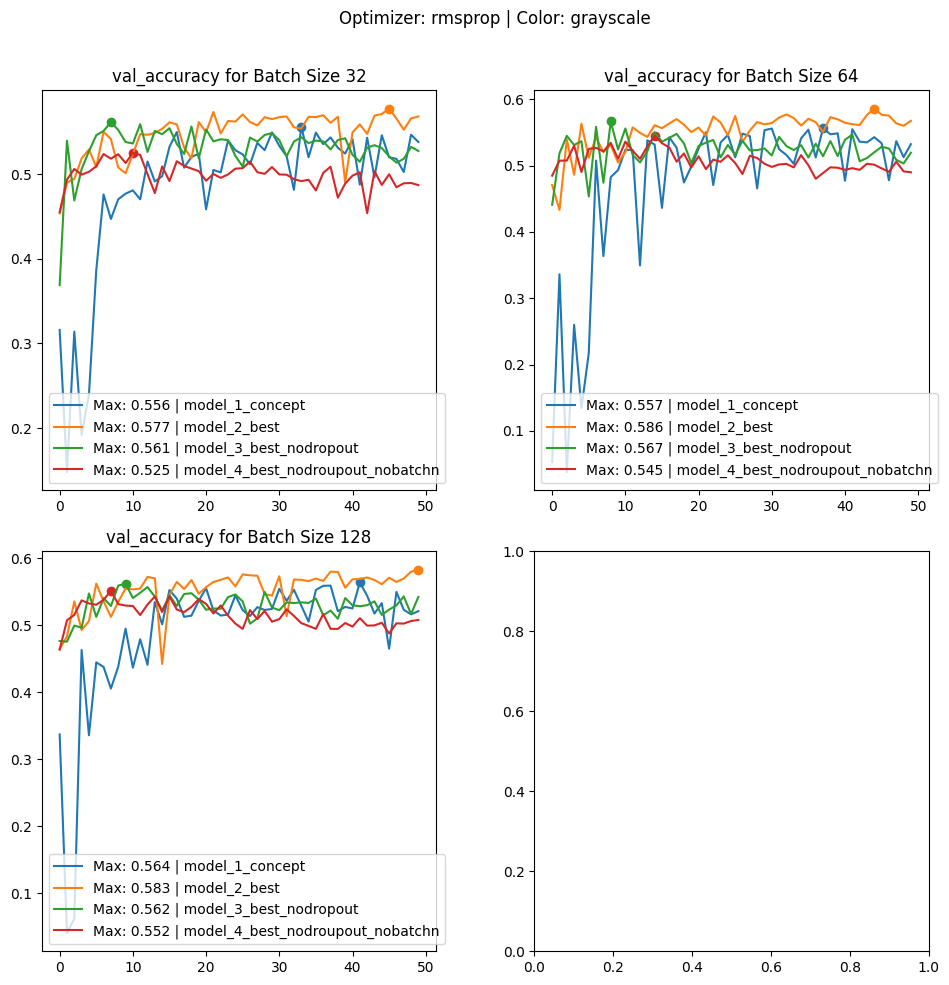

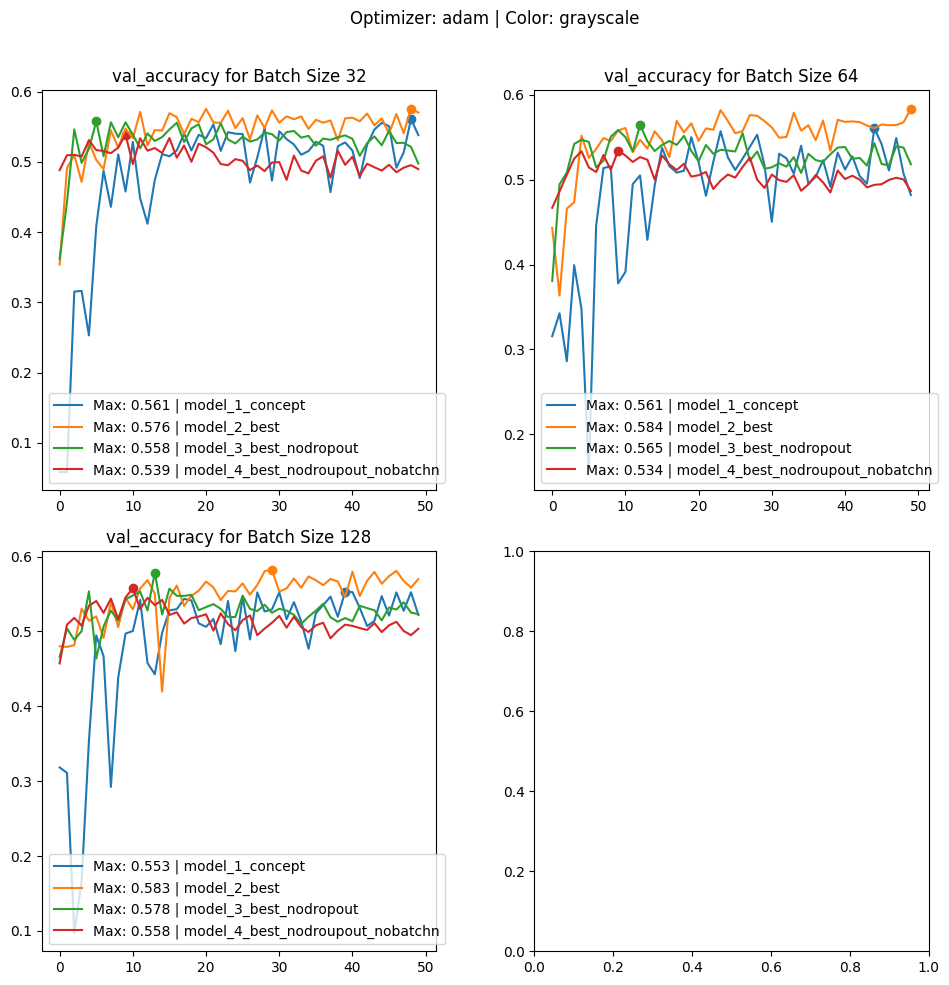

In [5]:
# Model regex pattern
regex_pattern = r'(model_\d+_[\w_]+)_(adam|rmsprop|sgd)_(rgb|grayscale)_(\d+)_augment_history\.json'

def plot_metric(folder_path, metric='val_accuracy', optimizer='', color_mode='', batch_sizes=[]):
    models = set()
    metrics = {batch_size: {} for batch_size in batch_sizes}

    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)
                match = re.match(regex_pattern, filename)
                if match:
                    _model_name = match.group(1)
                    _optimizer = match.group(2)
                    _color_mode = match.group(3)
                    _batch_size = match.group(4)

                    if (
                        optimizer == _optimizer and
                        color_mode == _color_mode and
                        int(_batch_size) in batch_sizes
                    ):
                        models.add(_model_name)
                        metrics[int(_batch_size)][_model_name] = data[metric]

    # Sort models alphabetically
    sorted_models = sorted(models)

    # Create a color map for each unique model
    colors = iter(cm.tab10.colors)
    model_color_map = {model: next(colors) for model in sorted_models}

    # Plotting in subplots
    num_rows = len(batch_sizes) // 2 + len(batch_sizes) % 2  # Calculate the number of rows
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(10, 5 * num_rows))

    for i, batch_size in enumerate(batch_sizes):
        row = i // 2
        col = i % 2

        for model in sorted_models:
            history = metrics[batch_size].get(model, [])
            color = model_color_map[model]
            # Add dot on the graph for the numeric label at the highest value
            max_value_index = history.index(max(history))
            max_value = max(history)
            axes[row, col].scatter(max_value_index, max_value, color=color)
            axes[row, col].plot(history, label=f'Max: {max_value:.3g} | {model}', color=color)

        axes[row, col].set_title(f'{metric} for Batch Size {batch_size}')
        axes[row, col].legend()

    plt.suptitle(f'Optimizer: {optimizer} | Color: {color_mode}')
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust subplot layout to include suptitle
    plt.show()

# Example usage with different batch sizes
plot_metric(folder_path, metric='val_accuracy', optimizer='sgd', color_mode='rgb', batch_sizes=[32, 64, 128, 256])
plot_metric(folder_path, metric='val_accuracy', optimizer='rmsprop', color_mode='rgb', batch_sizes=[32, 64, 128, 256])
plot_metric(folder_path, metric='val_accuracy', optimizer='adam', color_mode='rgb', batch_sizes=[32, 64, 128, 256])
plot_metric(folder_path, metric='val_accuracy', optimizer='sgd', color_mode='grayscale', batch_sizes=[32, 64, 128])
plot_metric(folder_path, metric='val_accuracy', optimizer='rmsprop', color_mode='grayscale', batch_sizes=[32, 64, 128])
plot_metric(folder_path, metric='val_accuracy', optimizer='adam', color_mode='grayscale', batch_sizes=[32, 64, 128])

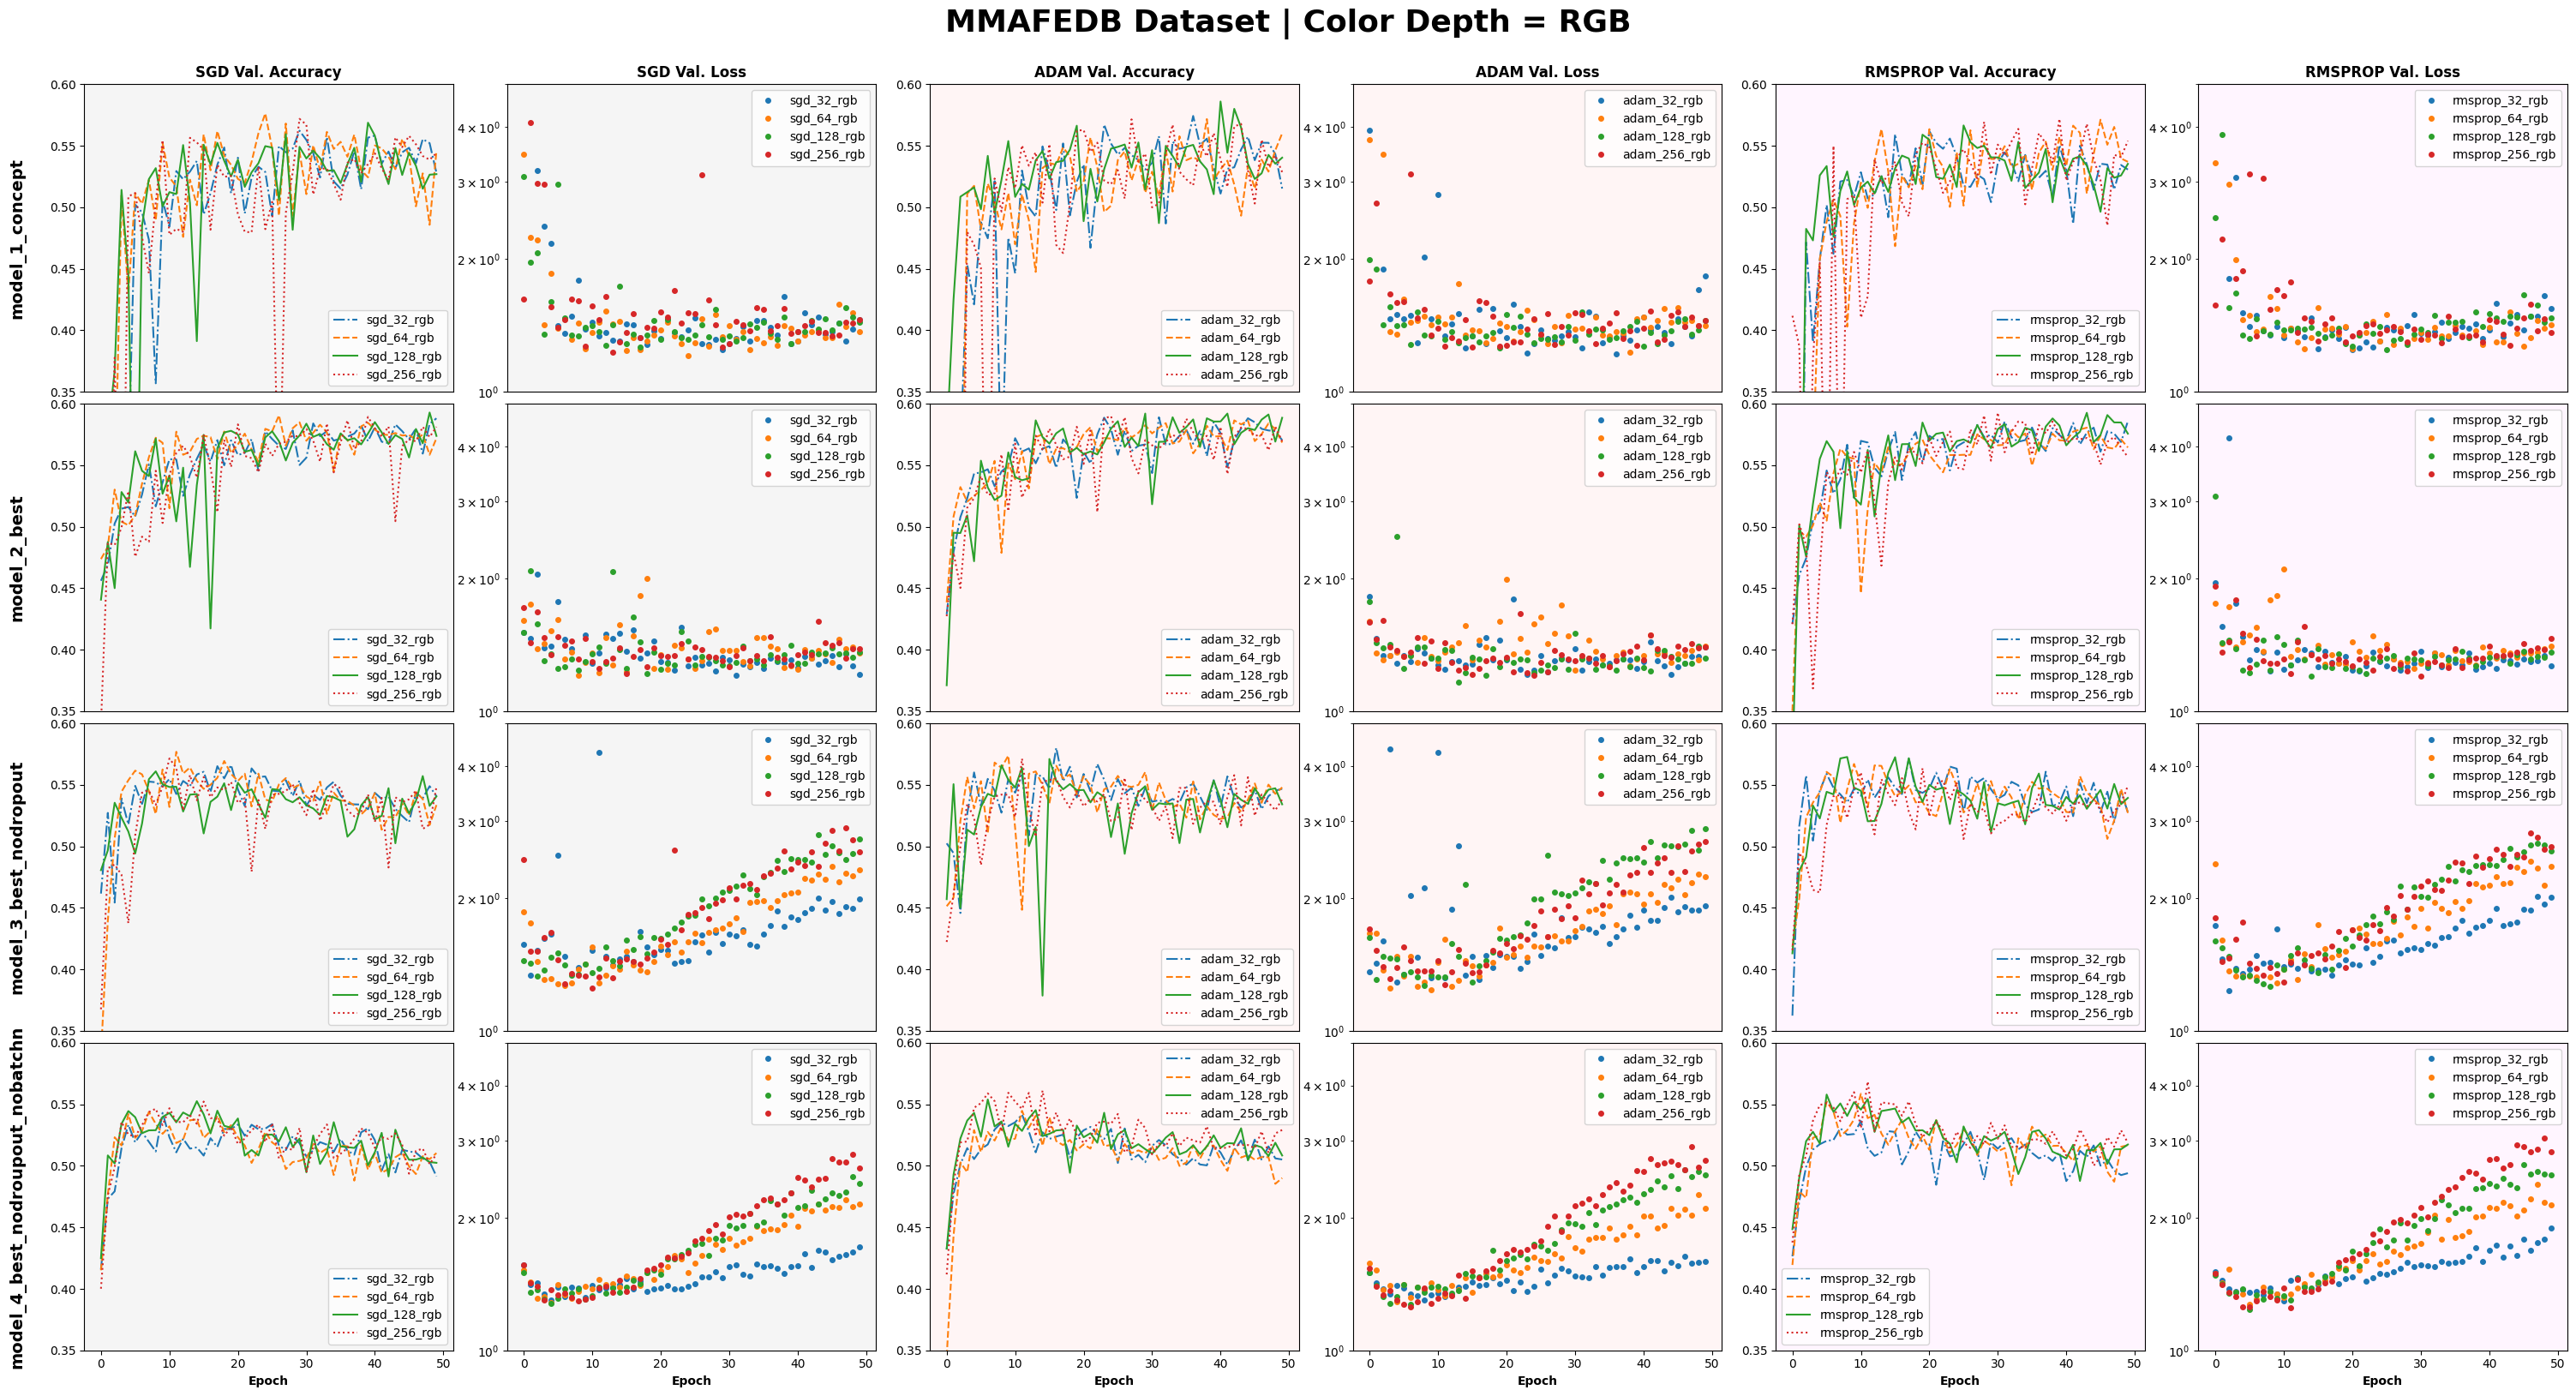

In [52]:
import os
import json
import re
import matplotlib.pyplot as plt

# Model regex pattern
regex_pattern = r'(model_\d+_[\w_]+)_(adam|rmsprop|sgd)_(rgb|grayscale)_(\d+)_augment_history\.json'

def plot_single_model(folder_path,optimizers=['sgd', 'adam', 'rmsprop'],batch_sizes=[32, 64, 128, 256],color_modes=['rgb']):
    # Create a figure with three subplots in a single row
    fig, axs = plt.subplots(len(models), 6, figsize=(30, 4 * len(models)))
    fig.suptitle(f'MMAFEDB Dataset | Color Depth = {color_modes[0].upper()}',weight='bold',fontsize=26, y=1.01)

    for model_num, model_name in enumerate(models):
        for i, optimizer in enumerate(optimizers):
            metrics = {}

            for filename in os.listdir(folder_path):
                if filename.endswith(".json"):
                    file_path = os.path.join(folder_path, filename)
                    with open(file_path, 'r') as file:
                        data = json.load(file)
                        match = re.match(regex_pattern, filename)
                        if match:
                            _model_name = match.group(1)
                            _optimizer = match.group(2)
                            _color_mode = match.group(3)
                            _batch_size = int(match.group(4))

                            if _model_name == model_name and _optimizer == optimizer \
                                    and _batch_size in batch_sizes and _color_mode in color_modes:
                                key = f'{_optimizer}_{_batch_size}_{_color_mode}'
                                metrics[key] = {'accuracy': data['val_accuracy'], 'loss': data['val_loss']}

            # Define a custom sorting function to sort by batch size and color mode
            def custom_sort(key):
                _, batch_size, color_mode = key.split('_')
                return (int(batch_size), color_mode)

            # Sort keys using the custom sorting function
            sorted_keys = sorted(metrics.keys(), key=custom_sort)

            # Define line styles for accuracy plots and use dots for loss plots
            line_styles = ['-.', '--', '-', ':']

            for j, key in enumerate(sorted_keys):
                history = metrics[key]
                axs[model_num, i * 2].plot(history['accuracy'], label=f'{key}', linestyle=line_styles[j % len(line_styles)])
                axs[model_num, i * 2].set_yscale('linear')
                axs[model_num, i * 2].legend()

                axs[model_num, i * 2 + 1].plot(history['loss'], label=f'{key}', linestyle=' ', marker='o', markersize=4)
                axs[model_num, i * 2 + 1].set_yscale('log')
                axs[model_num, i * 2 + 1].legend()
                axs[model_num, i * 2].set_ylim(0.35, 0.60)
                axs[model_num, i * 2 + 1].set_ylim(1, 5)
                
                if(model_num == 0):
                    axs[model_num, i * 2].set_title(f'{optimizer.upper()} Val. Accuracy',weight='bold')
                    axs[model_num, i * 2 + 1].set_title(f'{optimizer.upper()} Val. Loss',weight='bold')
                
                if(model_num == len(models)-1):
                    axs[model_num, i * 2].set_xlabel(f'Epoch',weight='bold')
                    axs[model_num, i * 2 + 1].set_xlabel(f'Epoch',weight='bold')
                    axs[model_num, i * 2].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
                    axs[model_num, i * 2 + 1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
                else:
                    axs[model_num, i * 2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
                    axs[model_num, i * 2 + 1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

                axs[model_num, 0].set_ylabel(model_name, weight='bold', fontsize=14, labelpad=20)
                
    # Set common y-axis limits for accuracy and loss subplots
    for i in range(len(models)):
        axs[i, 0].set_ylim(0.35, 0.60)
        axs[i, 1].set_ylim(1, 5)

        axs[i, 0].patch.set_facecolor('#F5F5F5')  # Light Gray
        axs[i, 1].patch.set_facecolor('#F5F5F5')  # Light Gray

        axs[i, 2].patch.set_facecolor('#FFF5F5')  # Lighter Pink
        axs[i, 3].patch.set_facecolor('#FFF5F5')  # Lighter Pink

        axs[i, 4].patch.set_facecolor('#FFF5FF')  # Lighter Purple
        axs[i, 5].patch.set_facecolor('#FFF5FF')  # Lighter Purple
    
    # Adjust layout for better spacing
    plt.tight_layout(pad=0.5,h_pad=0.0,w_pad=0.3)
    plt.show()

# Example usage for specific models
models = ['model_1_concept', 'model_2_best', 'model_3_best_nodropout', 'model_4_best_nodroupout_nobatchn']
plot_single_model(folder_path)


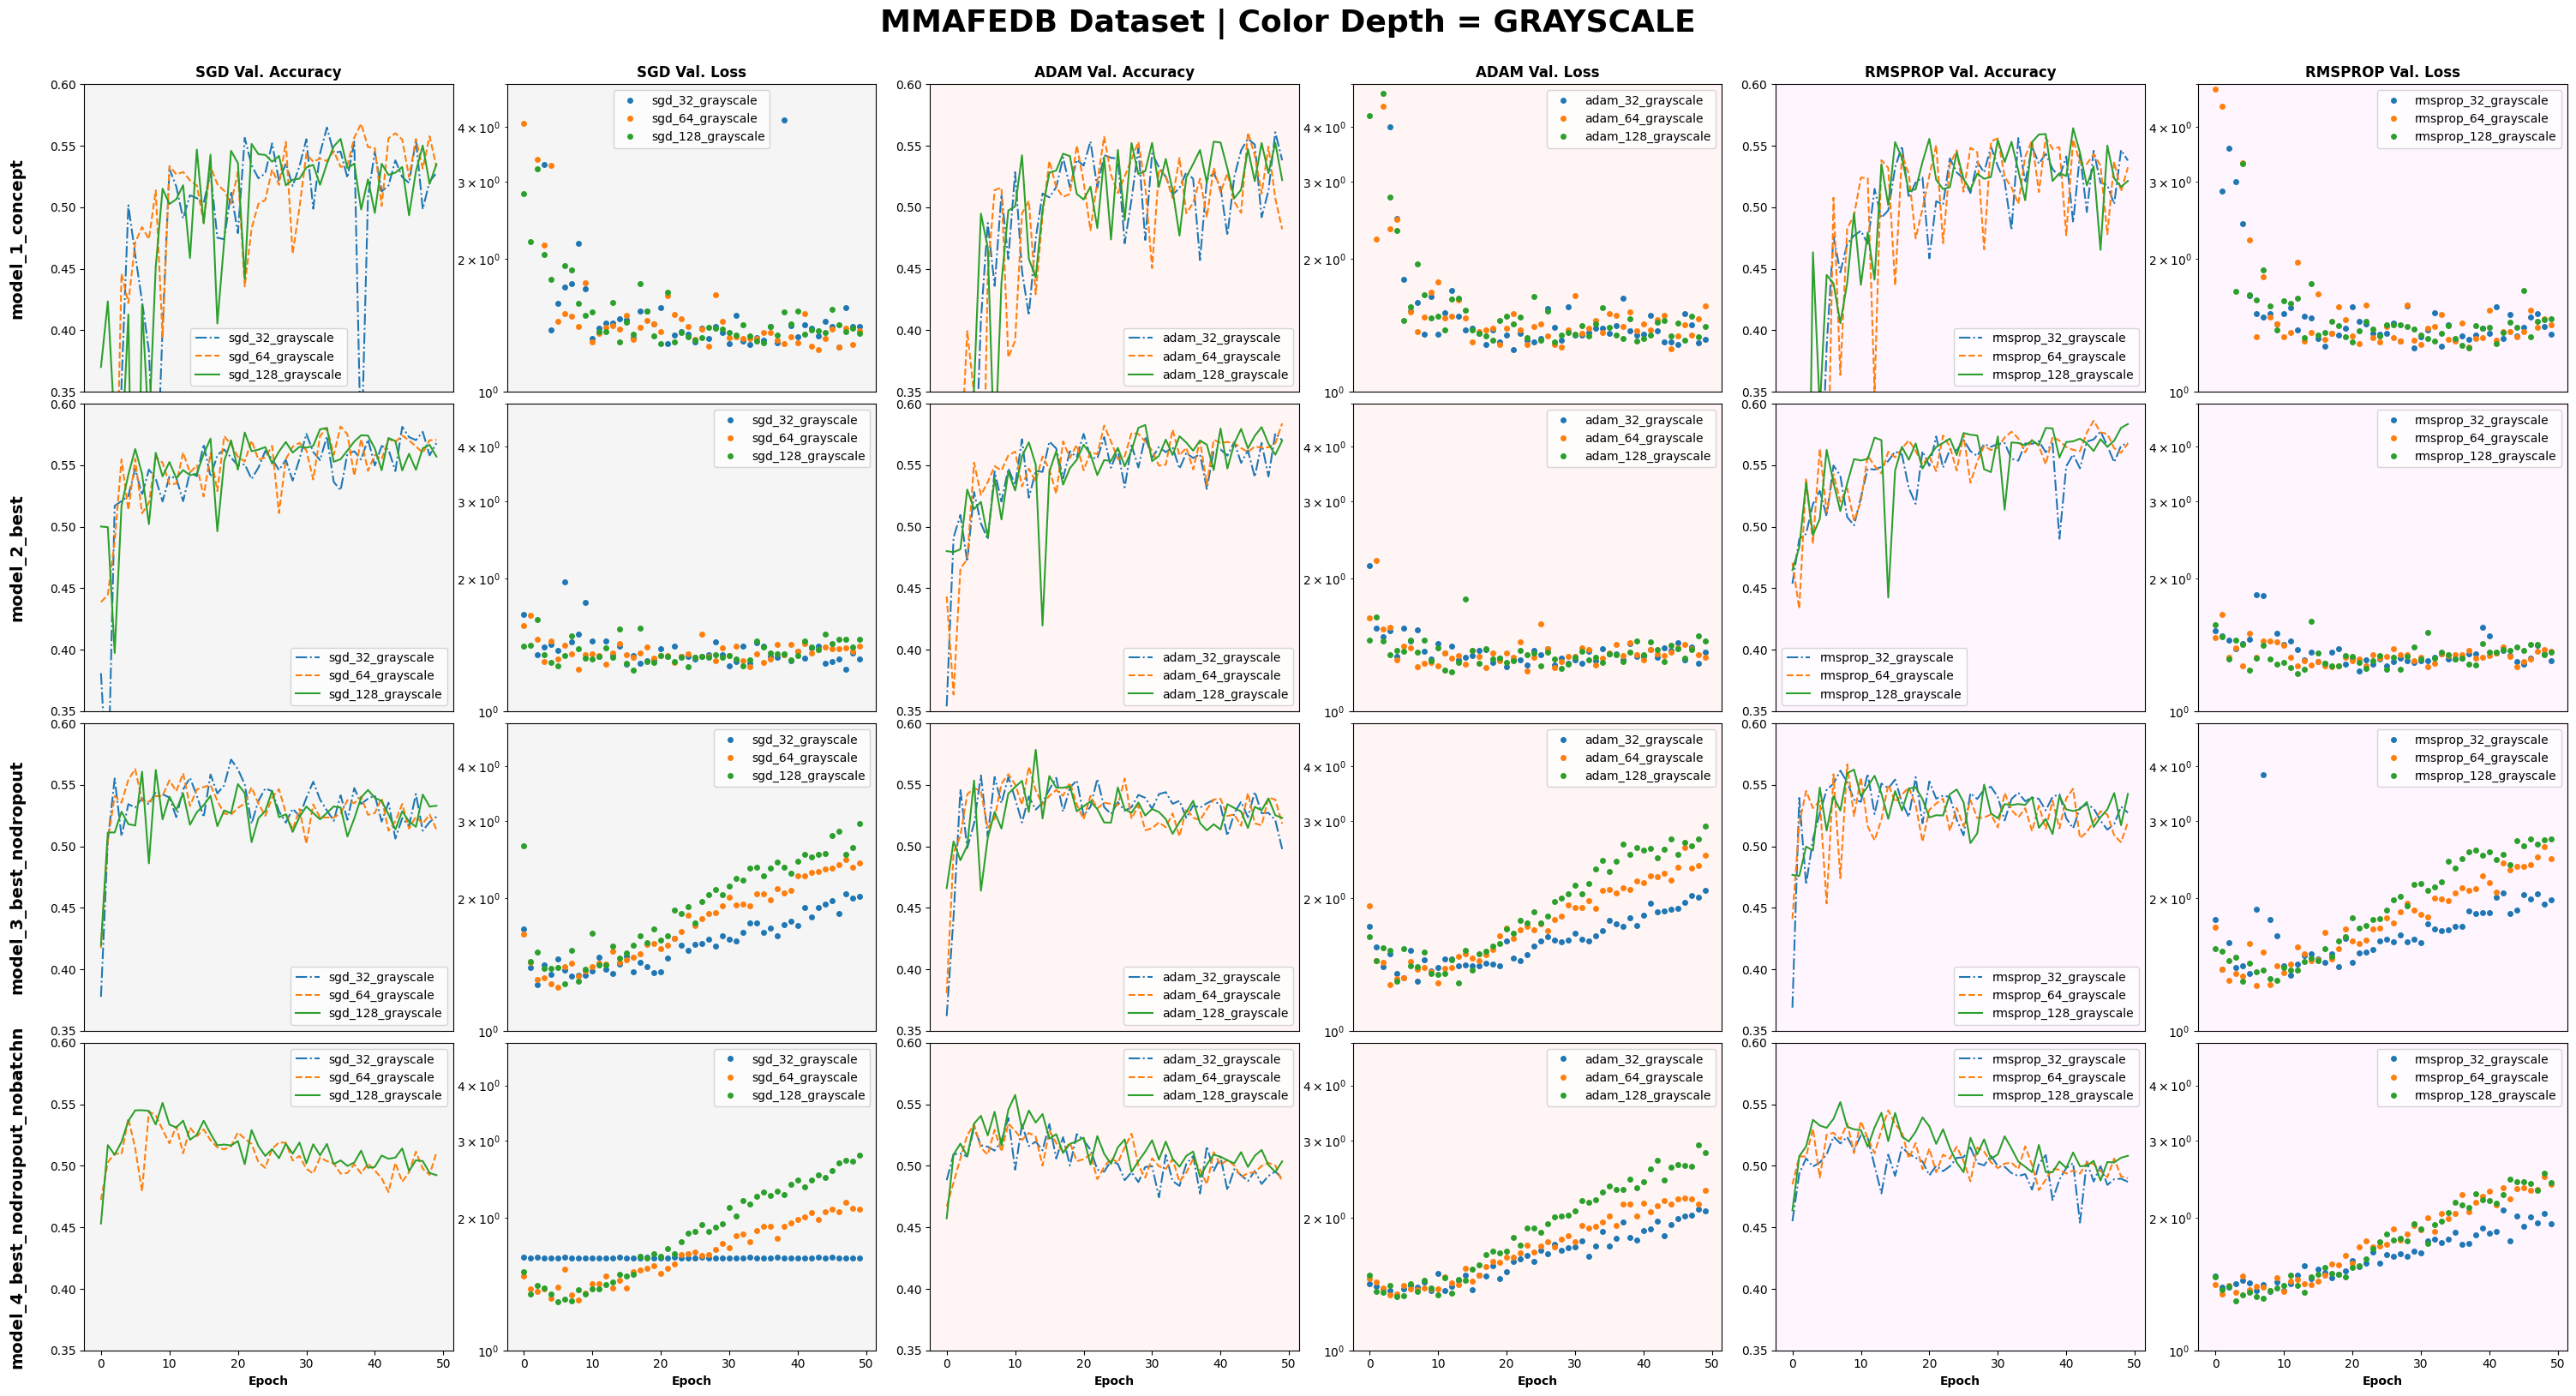

In [53]:
plot_single_model(folder_path,color_modes=['grayscale'])